python 2.7, sklearn 1.8

Groupe :


Pascal DAMESIN


Sidoine KAKEUH FOSSO


Damien RUSSIER


Nicolas YOUNES

# Objectif

Chaque objet connecté possède un unique identifiant (did), et envoie 1 ou plusieurs messages (objid) à plusieurs stations (bsid) au cours du temps. Certains objets sont localisés par GPS : jeu d'entraînement.

L'objectif est de localiser, pour chaque message envoyé, les objets non équipés de GPS, ie localiser le couple (objet, message).

On dispose d'informations supplémentaires, comme le temps d'arrivée du message à la station, ainsi que la puissance (dB) du signal mesurée au niveau de la station. Cette mesure est peu fiable (pas proportionnelle à l'inverse de la distance au carré), notamment en raison des nombreuses réflexions multiples subies par un signal avant de parvenir à une station.

# Fonctions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from geopy.distance import vincenty

sns.set(style='whitegrid', context='notebook')

In [2]:
def write_to_csvfile(filename, ylat, ylng):
    """write predicted values to csv file"""
    test_res = pd.DataFrame(np.array([ylat, ylng]).T, columns = ['lat', 'lng'])
    test_res.to_csv(filename + '.csv', index=False)
    print test_res.head()

In [3]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters
                        for m in range(vec_coord.shape[0])]
    return vin_vec_dist


def dist_geoloc(y_train_lat, y_train_lng, y_pred_lat, y_pred_lng):
    """mesure de distance fournie par geopy"""
    vec_coord = np.array([[y_train_lat] , [y_train_lng], [y_pred_lat], [y_pred_lng]])
    d = vincenty_vec(np.transpose(vec_coord))
    print "distance : ", d
    return d


# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat, y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec


# quelques tests
dist_geoloc(40.74838, -73.996705, 40.74838, -73.996705)
dist_geoloc(41.74838, -73.996705, 40.74838, -73.996705)
dist_geoloc(0., 0., 90., 0.)

distance :  [0.0]
distance :  [111058.71589247158]
distance :  [10001965.729276339]


[10001965.729276339]

In [4]:
import math

def dist(latlon1, latlon2):
    lat1 = latlon1[0]
    lon1 = latlon1[1]
    lat2 = latlon2[0]
    lon2 = latlon2[1]
    R = 6371000. # earth's radius (m)
    phi1 = lat1 * math.pi / 180.
    phi2 = lat2 * math.pi / 180.
    Dphi = (lat2 - lat1) * math.pi / 180.
    Dlambda = (lon2 - lon1) * math.pi / 180.
    
    a = math.sin(Dphi / 2.) * math.sin(Dphi / 2.) +\
    math.cos(phi1) * math.cos(phi2) *\
    math.sin(Dlambda / 2.) * math.sin(Dlambda / 2.)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    # print "distance : ", d
    return d


def dist2(lat1, lon1, lat2, lon2):
    return dist((lat1, lon1), (lat2, lon2))


# quelques tests
print dist((40.74838, -73.996705), (40.74838, -73.996705))
print dist((41.74838, -73.996705), (40.74838, -73.996705))
print dist((0., 0.), (180., 0.)), math.pi * 6371000.

0.0
111194.926645
20015086.796 20015086.796


In [5]:
import time

# print run time
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
#         print '%r (%r, %r) %2.2f sec' % \
#               (method.__name__, args, kw, te-ts)
        print '%r %2.2f sec' % \
              (method.__name__, te-ts)
        return result
    return timed

# Lecture des données

In [6]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [7]:
df_mess_train.head()

objid  bsid       did  nseq   rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.5  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.0  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0 -134.0  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.0  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.0  1.463553e+12   

      bs_lat      bs_lng  
0  39.617794 -104.954917  
1  39.677251 -104.952721  
2  39.612745 -105.008827  
3  39.797969 -105.073460  
4  39.723151 -104.956216

In [8]:
pos_train.head()

lat         lng
0  39.606690 -104.958490
1  39.606690 -104.958490
2  39.637741 -104.958554
3  39.730417 -104.968940
4  39.730417 -104.968940

Pour le jeu d'entraînement, il est possible de combiner les données regroupant les coordonnées des stations avec celles des messages correspondants

In [9]:
# combine dataframes to compute distances between device and bases
df_mess_pos_train = df_mess_train.join(pos_train)
df_mess_pos_train['dist_m'] = np.vectorize(dist2)(
    df_mess_pos_train['bs_lat'], df_mess_pos_train['bs_lng'],
    df_mess_pos_train['lat']   , df_mess_pos_train['lng'])

df_mess_pos_train['dist_km'] = df_mess_pos_train['dist_m'] / 1000.

# signal in dB and real power
df_mess_pos_train.rename(columns={'rssi': 'rssi_dB'}, inplace=True)
df_mess_pos_train['rssi'] = np.exp(df_mess_pos_train['rssi_dB'] / 20.)

# print df_mess_pos_train.head()
print df_mess_pos_train.describe()


               bsid           did          nseq       rssi_dB       time_ux  \
count  39250.000000  3.925000e+04  39250.000000  39250.000000  3.925000e+04   
mean    4533.774752  4.835932e+05      1.043541   -125.863580  1.473368e+12   
std     2570.495638  9.893140e+04      0.563540      9.226500  5.506910e+09   
min      879.000000  4.732880e+05      0.000000   -155.000000  1.463546e+12   
25%     2790.000000  4.761230e+05      1.000000   -132.500000  1.468410e+12   
50%     3559.000000  4.763150e+05      1.000000   -127.333333  1.473444e+12   
75%     7456.000000  4.766090e+05      1.500000   -121.000000  1.479118e+12   
max    11951.000000  1.747448e+06      2.000000    -64.000000  1.481143e+12   

             bs_lat        bs_lng           lat           lng        dist_m  \
count  39250.000000  39250.000000  39250.000000  39250.000000  3.925000e+04   
mean      42.554998   -100.969685     39.783333   -105.056343  4.100715e+05   
std        7.722787     11.522732      0.206262    

Certaines stations du jeu de test sont absentes du jeu d'entraînement. On liste toutes les stations en utilisant donc les 2 jeux de données.

In [10]:
# determine all Base stations that received at least 1 message
listOfBs = np.union1d(np.unique(df_mess_train['bsid']),
                      np.unique(df_mess_test['bsid']))
print "nb stations : ", len(listOfBs)

nb stations :  259


In [11]:
# are some stations in test and not in train ?

bsTrain = set(np.unique(df_mess_train['bsid']))
bsTest  = set(np.unique(df_mess_test['bsid']))
# difference
# print set.intersection(bsTrain, bsTest)
print "nb stations train            : ", len(bsTrain)
print "nb stations test             : ", len(bsTest)
print "nb stations in both datasets : ", len(set.intersection(bsTrain, bsTest))
print "nb stations not in train     : ", len(bsTest - bsTrain)
print bsTest - bsTrain

nb stations train            :  251
nb stations test             :  168
nb stations in both datasets :  160
nb stations not in train     :  8
set([8168, 1131, 9936, 3828, 9941, 9783, 3034, 9949])


# Exploration des données

On étudie ici la distribution des données, ainsi que les éventuelles anomalies à éliminer

In [12]:
# group data by message for visualization
bases_obj = df_mess_pos_train[['objid', 'lat', 'lng', 'bsid', 'bs_lat', 'bs_lng']].groupby(['objid'])

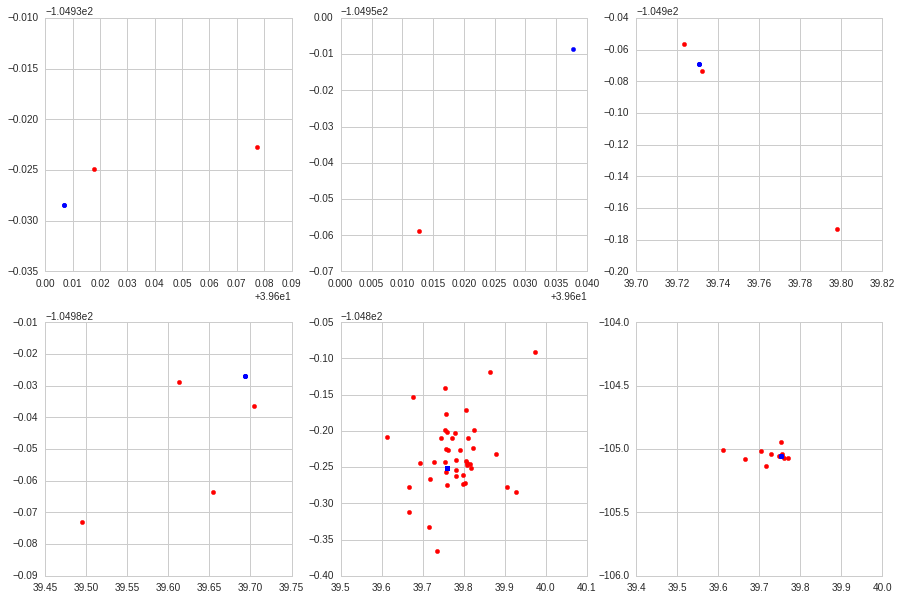

In [13]:
# plot some stations and device x=lat, y=lng

from matplotlib import gridspec

N = 6
cols = 3
rows = 2

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(15, 10))

i = 0
for key, elmt in bases_obj:
    ax = fig.add_subplot(gs[i])
    
    # print key, elmt
    e = bases_obj.get_group(key)
    # print e
    
    plt.scatter(e.bs_lat, e.bs_lng, color='r')
    plt.scatter(e.lat, e.lng, color='b')
    
    i += 1
    if i == N:
        break

plt.xlim([39.4, 40])
plt.ylim([-106, -104])
plt.show()

Le nombre de stations réceptrices par message est très variable.

Intuitivement, la position d'un message n'est pas très éloignée du barycentre des stations réceptrices. cette idée sera mise en oeuvre par la suite pour la formulation du problème inverse à résoudre.

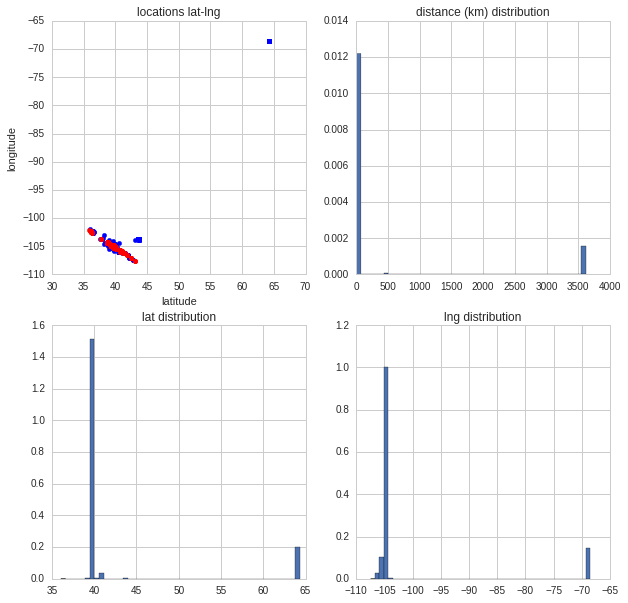

In [14]:
# plot lat, lng and distance distributions :
# outliers appear : distances around 3500 km (sigfox device <= 30 km)

fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(df_mess_pos_train['bs_lat'], df_mess_pos_train['bs_lng'], color='b')
plt.scatter(df_mess_pos_train['lat'],    df_mess_pos_train['lng'],    color='r')
plt.title('locations lat-lng')
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.subplot(222)
plt.title('distance (km) distribution')
plt.hist(df_mess_pos_train['dist_km'], bins=50, normed=True)

plt.subplot(223)
plt.title('lat distribution')
plt.hist(df_mess_pos_train['bs_lat'], bins=50, normed=True)

plt.subplot(224)
plt.title('lng distribution')
plt.hist(df_mess_pos_train['bs_lng'], bins=50, normed=True)
plt.show()

Sur les graphes ci-dessus, on distingue des messages pour lesquels une station réceptrice est éloignée de plusieurs centaines de kilomètres (valeurs autour de 500 et 3500 km sur l'histogramme en haut à droite).

On supprime les données pour lesquelles la distance est supérieure à 50 km (la portée d'un message est normalement de l'ordre de 30 km)

In [15]:
# remove lines where distance device -> station >= 50 km
nraw = df_mess_pos_train.shape[0]
print "nb samples in raw data             : ", nraw
df_mess_pos_train = df_mess_pos_train.loc[df_mess_pos_train['dist_km'] < 50]
nout = df_mess_pos_train.shape[0]
print "nb samples after removing outliers : ", nout
print "percentage of  outliers            : ", 100. * (1 - 1. * nout / nraw)

nb samples in raw data             :  39250
nb samples after removing outliers :  34655
percentage of  outliers            :  11.7070063694


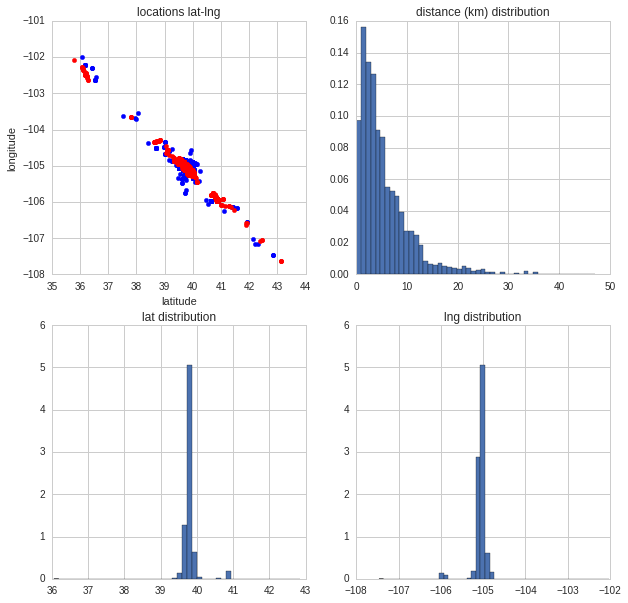

In [16]:
# same plot with outliers removed
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(df_mess_pos_train['bs_lat'], df_mess_pos_train['bs_lng'], color='b')
plt.scatter(df_mess_pos_train['lat'],    df_mess_pos_train['lng'],    color='r')
plt.title('locations lat-lng')
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.subplot(222)
plt.title('distance (km) distribution')
plt.hist(df_mess_pos_train['dist_km'], bins=50, normed=True)

plt.subplot(223)
plt.title('lat distribution')
plt.hist(df_mess_pos_train['bs_lat'], bins=50, normed=True)

plt.subplot(224)
plt.title('lng distribution')
plt.hist(df_mess_pos_train['bs_lng'], bins=50, normed=True)
plt.show()

Les coordonnées des messages sont-elles linéairement corrélées avec celles des stations ?

In [17]:
# plot variables correlations
cols = ['rssi', 'time_ux', 'bs_lat', 'bs_lng', 'lat', 'lng', 'dist_km']
cols2 = ['bs_lat', 'bs_lng', 'lat', 'lng']

sns.pairplot(df_mess_pos_train[cols2], size=2.5)
plt.tight_layout()
plt.show()

In [18]:
# correlation matrix between all variables
cm = np.corrcoef(df_mess_pos_train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.show()

Les latitudes des stations et des messages sont fortement linéairement corrélées. Idem pour les longitudes. Cela justifie le choix d'une régression linéaire comme 1ère approche.

# Problème inverse

##  1. Formulation

On considère que la position d'un message est une combinaison linéaire de celles des stations allumées correspondantes :

$\boldsymbol{x}_i \simeq \sum_{j(stations)} \delta_i^j w_j \boldsymbol{b}_j$


au lieu de

$\boldsymbol{x}_i \simeq \sum_{j(stations)} \delta_i^j w_j$ (modèle proposé pendant la séance)




On résout le problème inverse suivant :


$arg\ min_w J(w) = \sum_{i(messages)} ||\boldsymbol{x}_i - \sum_{j(stations)} \delta_i^j w_j \boldsymbol{b}_j||^2$

où $\delta_i^j$ signifie : station j allumée pour message i (ce n'est pas le symbole de Kronecker ici !)



Terme général de la matrice :
$\boldsymbol{b}_i^t \boldsymbol{b}_j \sum_k \delta_k^i \delta_k^j$


Membre de droite:
$\boldsymbol{b}_i^t \sum_k \delta_k^j \boldsymbol{x}_k$
base i et somme des coordonnées des messages allumés pour cette base

## 2. Mise en oeuvre

In [19]:
def nbval_dict(d):
    nb = 0
    lst = [len(d[key]) for key in d.keys()]
    return sum(lst)


def build_matrix(df_mess_pos, listOfBs, objects=False):
    """
    build linear model matrix
    objects : return dictionnary did : [indices of corresponding messages in features matrix]
    """
    df_mess_bs_group = df_mess_pos.groupby(['objid'], as_index=False) # group data by message (objid)
    nb_mess = len(np.unique(df_mess_pos['objid']))
    Xlat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    Xlng = Xlat.copy()
    idx = 0
    
    obj = {}
    for key, elmt in df_mess_bs_group:
        gr = df_mess_bs_group.get_group(key)
        did = gr.did.iloc[0]
        if did in obj.keys():
            obj[did].append(idx)
        else:
            obj[did] = [idx]
            
        Xlat.loc[idx, gr['bsid']] = gr.bs_lat.iloc[0]
        Xlng.loc[idx, gr['bsid']] = gr.bs_lng.iloc[0]
        idx = idx + 1
    
    if objects :
        return Xlat, Xlng, obj
    else:
        return Xlat, Xlng


def check_matrix(X):
    """check sparse matrix of features (for debug)"""
    tmp1 = X.iloc[0]
    tmp2 = tmp1[tmp1 != 0]
    print tmp2

    
def build_ground_truth(df_mess_pos):
    """compute average value of device coordinates (training test)"""
    # pour un même (objet, message), les labels (lat, lon) peuvent être légèrement différents
    # => on les moyenne
    ylat = np.array(df_mess_pos.groupby(['objid']).mean()['lat'])
    ylng = np.array(df_mess_pos.groupby(['objid']).mean()['lng'])
        
    return ylat, ylng


def build_ground_truth_baryc(Xlat, Xlng):
    """compute barycenter of stations, for each device"""
    
    def compute_baryc(X):
        tab = np.zeros(X.shape[0])
        for irow in range(X.shape[0]):
            lst = []
            tmp1 = np.array(X.iloc[irow])
            # print tmp1
            tmp2 = tmp1[tmp1 != 0]
            # print tmp2
        
            tab[irow] = np.mean(tmp2)
        return tab
    
    ylat_baryc = compute_baryc(Xlat)
    ylng_baryc = compute_baryc(Xlng)
        
    return ylat_baryc, ylng_baryc

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from copy import deepcopy
from sklearn.cross_validation import train_test_split
from joblib import Parallel, delayed


def fit_predict(params): # params = (reg, X, y, ysum, ind)
    """
    function to be 'pickled' for parallel computing of lat and lng models
    """
    reg = params[0]
    X = params[1]
    y = params[2]
    ysum = params[3]
    ind = params[4]
            
    # fit
    reg.fit(X, y)
            
    # predict
    y_pred = reg.predict(X)
            
    # add predicted values to output vector
    ysum[ind] += y_pred
    return ysum


class PositionEstimator():
    def __init__(self, listOfBs, estimator, baryc=False, dbg=False):
        self.listOfBs = listOfBs
        self.reg = [estimator, deepcopy(estimator)]
        self.baryc = baryc
        self.dbg = dbg
    
    def fit(self, df_mess_pos):
        """
        fit the model
        """
        self.Xlat, self.Xlng = build_matrix(df_mess_pos, self.listOfBs)
        self.ylat, self.ylng = build_ground_truth(df_mess_pos)
        
        if self.dbg:
            check_matrix(self.Xlat)
            check_matrix(self.Xlng)
            print self.ylat, self.ylng
        
        if self.baryc:
            self.ylat_baryc, self.ylng_baryc = build_ground_truth_baryc(self.Xlat, self.Xlng)
        else:
            self.ylat_baryc = np.zeros(self.ylat.shape)
            self.ylng_baryc = np.zeros(self.ylng.shape)
        self.reg[0].fit(self.Xlat, self.ylat - self.ylat_baryc)
        self.reg[1].fit(self.Xlng, self.ylng - self.ylng_baryc)
        
        return self
    
    def predict(self, df_mess, train=True):
        """
        train : flag to avoid building new matrix (time consuming)
        """
        if train:
            ylat_pred = self.reg[0].predict(self.Xlat) + self.ylat_baryc
            ylng_pred = self.reg[1].predict(self.Xlng) + self.ylng_baryc
        else:
            Xlat, Xlng = build_matrix(df_mess, self.listOfBs)
            if self.baryc:
                ylat_baryc, ylng_baryc = build_ground_truth_baryc(Xlat, Xlng)
                ylat_pred = self.reg[0].predict(Xlat) + ylat_baryc
                ylng_pred = self.reg[1].predict(Xlng) + ylng_baryc
            else:
                ylat_pred = self.reg[0].predict(Xlat)
                ylng_pred = self.reg[1].predict(Xlng)
        
        return ylat_pred, ylng_pred        
    
    def score(self, df_mess_pos, train=True, cv=None):
        if cv is not None:
            if cv > 0:
                ylat_pred, ylng_pred = self.cvpredict(df_mess_pos, train=train, cv=cv)
            else:
                ylat_pred, ylng_pred = self.loopredict(df_mess_pos)
        else:
            ylat_pred, ylng_pred = self.predict(df_mess_pos, train=train)
        
        ylat, ylng = build_ground_truth(df_mess_pos)
        
        err_vec = Eval_geoloc(ylat, ylng, ylat_pred, ylng_pred)
        score = np.percentile(err_vec, 80) / 1000.
        print "score (percentile erreur à 80 %, en km) : ", score
        
        return err_vec
    
    def train_valid_fit(self, Xlat, Xlng, ylat, ylng):
        self.reg[0].fit(Xlat, ylat)
        self.reg[1].fit(Xlng, ylng)
        
        return self
    
    def train_valid_predict(self, Xlat, Xlng):
        ylat_pred = self.reg[0].predict(Xlat)
        ylng_pred = self.reg[1].predict(Xlng)
        
        return ylat_pred, ylng_pred
    
    def train_valid_score(self, df_mess_pos, test_size=0.3):
        """
        compute generalization error of the model :
        fit model on part of data, test on other part
        """
        Xlat, Xlng = build_matrix(df_mess_pos, self.listOfBs)
        ylat, ylng = build_ground_truth(df_mess_pos)
        Xlat_t, Xlat_v, ylat_t, ylat_v = train_test_split(
            Xlat, ylat, test_size=test_size, random_state=0)
        Xlng_t, Xlng_v, ylng_t, ylng_v = train_test_split(
            Xlng, ylng, test_size=test_size, random_state=0)
        
        self.train_valid_fit(Xlat_t, Xlng_t, ylat_t, ylat_t)
        ylat_pred, ylng_pred = self.train_valid_predict(Xlat_v, Xlng_v, ylat_v, ylat_v)
        
        
        err_vec = Eval_geoloc(ylat_v, ylng_v, ylat_pred, ylng_pred)
        score = np.percentile(err_vec, 80) / 1000.
        print "score (percentile erreur à 80 %, en km) : {:11.2f}".format(score)
        
        return err_vec
    
    
    def cvpredict(self, df_mess_pos, train=True, cv=10):
        """
        use cross validation function cross_val_predict
        baryc flag not coded yet
        """
        if train:
            ylat_pred = cross_val_predict(self.reg[0], self.Xlat, self.ylat, cv=cv)
            ylng_pred = cross_val_predict(self.reg[1], self.Xlng, self.ylng, cv=cv)
        else:
            Xlat, Xlng = build_matrix(df_mess_pos, self.listOfBs)
            ylat, ylng = build_ground_truth(df_mess_pos)
        
            ylat_pred = cross_val_predict(self.reg[0], Xlat, ylat, cv=10)
            ylng_pred = cross_val_predict(self.reg[1], Xlng, ylng, cv=10)
        
        return ylat_pred, ylng_pred
    

    def loopredict(self, df_mess_pos, n_jobs=2):
        # build full features matrix once
        Xlat, Xlng, objects = build_matrix(df_mess_pos, self.listOfBs, objects=True)
        ylat, ylng = build_ground_truth(df_mess_pos)
        
        # index rows of full matrix
        indices = range(Xlat.shape[0])
        
        # allocate arrays
        ylat_pred = np.zeros(ylat.shape)
        ylng_pred = np.zeros(ylng.shape)
        fold = np.zeros(ylat.shape)
                
        nobj = np.unique(df_mess_pos['did']).shape[0]
        for i, obj in enumerate(np.unique(df_mess_pos['did'])):
            print "loopredict : object nb {:03d}, completion % {:11.2f}".format(i, 100. * i / nobj)
            # indices of all messages corresponding to current device
            ind1 = objects[obj]
            # rows to keep in matrix
            ind2 = list(set(indices) - set(ind1))
            
            Xlat_tmp, ylat_tmp = Xlat.iloc[ind2], ylat[ind2]
            Xlng_tmp, ylng_tmp = Xlng.iloc[ind2], ylng[ind2]
            
            # print len(ind1), len(indices), len(ind2)
            # print Xlat_tmp.shape
            
            param_lst = [(self.reg[0], Xlat_tmp, ylat_tmp, ylat_pred, ind2),
                         (self.reg[1], Xlng_tmp, ylng_tmp, ylng_pred, ind2)]
            ylat_pred, ylng_pred = Parallel(n_jobs=n_jobs)(delayed(fit_predict)(t) for t in param_lst)
            
            # update fold
            fold[ind2] += 1.
        
        # average sum of predicted values
        ylat_pred /= fold
        ylng_pred /= fold
        
        return ylat_pred, ylng_pred
    
    
    @timeit
    def plot_error(self, df_mess_pos, train=True, cv=None):
        """compute error and plot distribution"""
        err_vec = self.score(df_mess_pos, train=train, cv=cv)
        
        values, base = np.histogram(err_vec, bins=50000)
        cumulative = np.cumsum(values) 

        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        
        plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
        plt.grid()
        plt.xlabel('Distance Error (km)')
        plt.ylabel('Cum proba (%)')
        plt.xlim([0, 30])
        plt.axis([0, 30, 0, 100])
        plt.title('Error Cumulative Probability')
        plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
        # plt.show()
    
        # plt.figure()
        plt.subplot(122)
        err = [x / 1000. for x in err_vec if x < 30000]
        plt.hist(err, bins=100, normed=True)
        plt.xlim([0, 30])
        plt.title('Error distribution')
        plt.show()

### a. Régression linéaire

In [22]:
pe1 = PositionEstimator(listOfBs, LinearRegression()) # LinearRegression() ExtraTreesRegressor()
pe1.fit(df_mess_pos_train)

<__main__.PositionEstimator instance at 0x7f0a74019878>

In [23]:
# error on training set
pe1.plot_error(df_mess_pos_train)

score (percentile erreur à 80 %, en km) :  7.72031079183


'plot_error' 2.20 sec


In [24]:
# cross-validation error
pe1.plot_error(df_mess_pos_train, cv=10)

score (percentile erreur à 80 %, en km) :  8.22137533889


'plot_error' 7.15 sec


Le modèle linéaire se généralise très bien en validation croisée : erreur de 8.2 km sur les données de test contre 7.7 km pour le jeu d'entraînement complet.

Ci-dessous, on propose deux autres modèles de régression.

### b.  K plus proches voisins

In [25]:
pe2 = PositionEstimator(listOfBs, KNeighborsRegressor(n_neighbors=5)) 
pe2.fit(df_mess_pos_train)

<__main__.PositionEstimator instance at 0x7f0a7c3781b8>

score (percentile erreur à 80 %, en km) :  3.10651743176


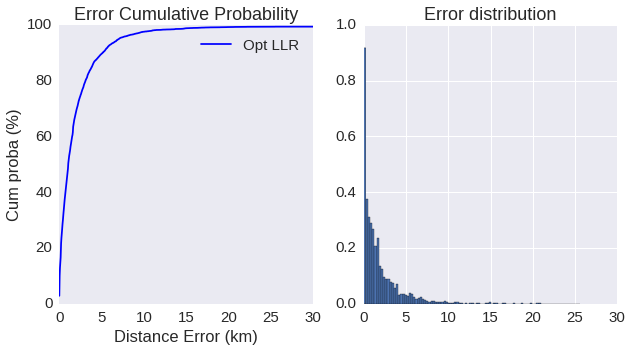

'plot_error' 66.08 sec


In [26]:
# error on training set
pe2.plot_error(df_mess_pos_train)

score (percentile erreur à 80 %, en km) :  3.91355234406


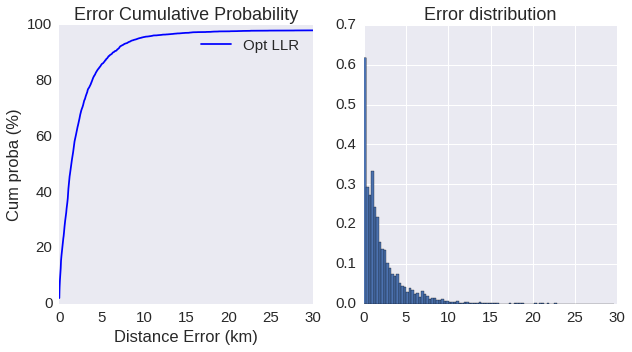

'plot_error' 66.43 sec


In [27]:
# cross-validation error
pe2.plot_error(df_mess_pos_train, cv=10)

L'estimateur par 4 plus proches voisins est remrquablement consistant : l'erreur en validation croisée (3.9 km) reste tout à fait acceptable comparé à l'erreur sur le jeu d'entrâinemeent (3.1 km).

On procède à deux validations croisées "leave-one-out" pour cet estimateur pour confirmer ce résultat :
- message leave-one-out
- puis device leave-one-out, comme demandé

score (percentile erreur à 80 %, en km) :  3.58807429603


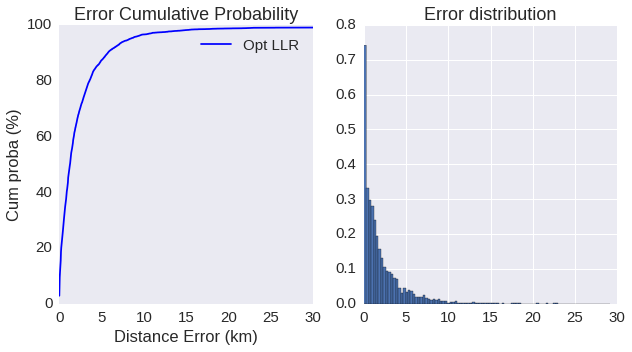

'plot_error' 1346.99 sec


In [35]:
# leave-one out per message = cross-validation with fold equal to number of samples
pe2.plot_error(df_mess_pos_train, cv=pe2.Xlat.shape[0])
# cv =   10  26.28
# cv =  100  47.87
# cv = 1000 247.44
# cv = 5869 1323.61

loopredict : object nb 000, completion %        0.00
loopredict : object nb 001, completion %        1.59
loopredict : object nb 002, completion %        3.17
loopredict : object nb 003, completion %        4.76
loopredict : object nb 004, completion %        6.35
loopredict : object nb 005, completion %        7.94
loopredict : object nb 006, completion %        9.52
loopredict : object nb 007, completion %       11.11
loopredict : object nb 008, completion %       12.70
loopredict : object nb 009, completion %       14.29
loopredict : object nb 010, completion %       15.87
loopredict : object nb 011, completion %       17.46
loopredict : object nb 012, completion %       19.05
loopredict : object nb 013, completion %       20.63
loopredict : object nb 014, completion %       22.22
loopredict : object nb 015, completion %       23.81
loopredict : object nb 016, completion %       25.40
loopredict : object nb 017, completion %       26.98
loopredict : object nb 018, completion %      

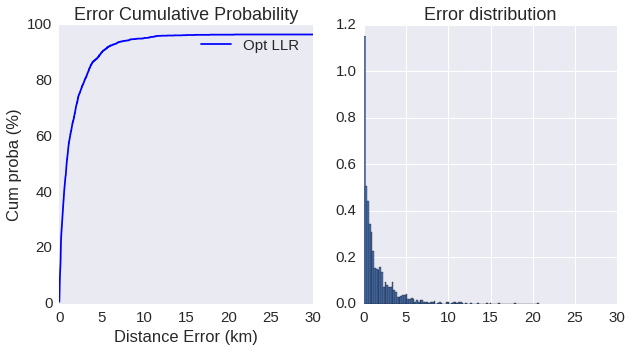

'plot_error' 141.66 sec


In [36]:
# leave-one-out cross-validation per device
# run only on 1/4 of the data (around 1 hour on full data)
pe2.plot_error(df_mess_pos_train[:10000], cv=-1)

In [28]:
ylat_pred, ylng_pred = pe2.predict(df_mess_test)
write_to_csvfile('neighbors', ylat_pred, ylng_pred)

         lat         lng
0  39.608901 -104.958658
1  39.657323 -105.008923
2  39.730963 -104.970283
3  39.692775 -105.006788
4  39.762452 -105.036436


### c. Arbres de régression

score (percentile erreur à 80 %, en km) :  1.57277410593


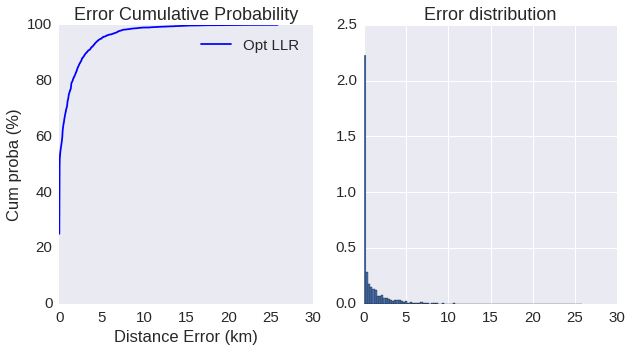

'plot_error' 2.28 sec


In [29]:
# try with extra trees regressor

pe3 = PositionEstimator(listOfBs, ExtraTreesRegressor()) # LinearRegression() ExtraTreesRegressor()
pe3.fit(df_mess_pos_train)
pe3.plot_error(df_mess_pos_train)

score (percentile erreur à 80 %, en km) :  4.10192768736


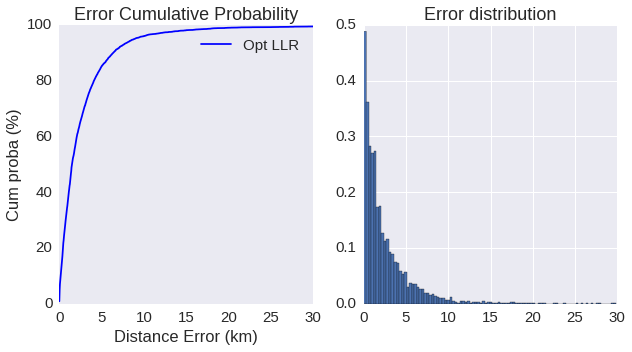

'plot_error' 127.02 sec


In [30]:
# cross-validation error
pe3.plot_error(df_mess_pos_train, cv=10)

Ce dernier modèle se généralise beaucoup moins bien que le précédent : erreur de 1.6 km sur le jeu d'entraînement, mais 4.1 km en validation croisée. Le modèle colle trop au jeu d'entraînement (overfit). 

## 3. Autre modèle proposé

Ici on considère que la position des messages est proche du barycentre des stations correspondantes:


$\boldsymbol{x}_i - \boldsymbol{x}_i^{baryc} \simeq \sum_{j(stations)} \delta_i^j w_j \boldsymbol{b}_j$

avec
$\boldsymbol{x}_i^{baryc} = \frac{\sum_{j(stations)} \delta_i^j \boldsymbol{b}_j}{\sum_{j(stations)} \delta_i^j }$

In [31]:
pe4 = PositionEstimator(listOfBs, LinearRegression(), baryc=True) # LinearRegression() ExtraTreesRegressor()
pe4.fit(df_mess_pos_train)

<__main__.PositionEstimator instance at 0x7f0a7666f710>

score (percentile erreur à 80 %, en km) :  5.68360689305


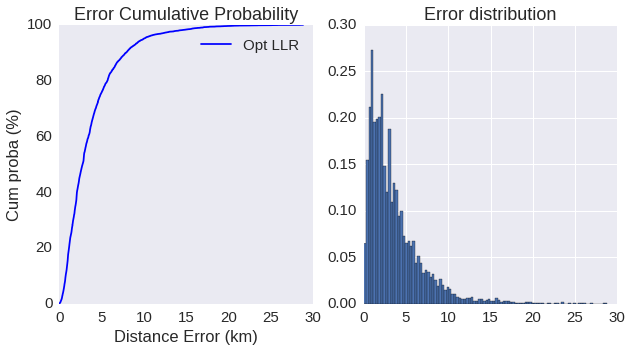

'plot_error' 2.39 sec


In [32]:
pe4.plot_error(df_mess_pos_train)

score (percentile erreur à 80 %, en km) :  8.22137533889


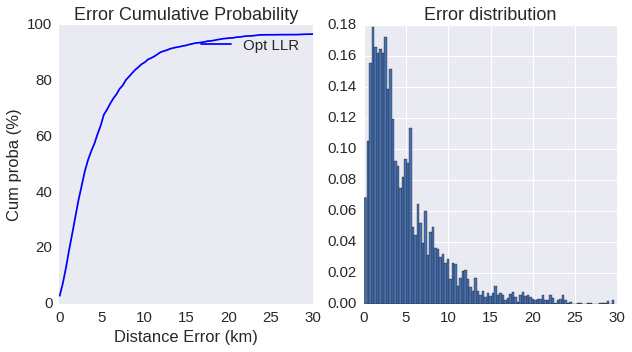

'plot_error' 6.54 sec


In [33]:
# training split into sub- training and test
pe4.plot_error(df_mess_pos_train, cv=10)

Ce modèle permet de diminuer sensiblement l'erreur sur le jeu d'entraînement (5.7 km contre 7.7 km avec la précédente régression linéaire), mais se généralise mal en validation croisée (8.2 km d'erreur).  

# Conclusion

Selon la précision souhaitée par Sigfox et ses clients, un modèle de régression linéaire tel que proposé ci-dessus pourra être ou non considéré comme suffisant.


Nous obtenons en effet une erreur (percentile à 80 %) de l'ordre de 3 km (régression plus proches voisins), à comparer avec la valeur du percentile à 75% de la distribution des distances des données brutes (9.8 km) ainsi qu'à la valeur médiane (4.7 km).


En termes mathématiques, une erreur sur l'estimation d'une grandeur, qui serait du même ordre que cette grandeur lorsqu'on peut la mesurer, n'est pas acceptable.
